<a href="https://colab.research.google.com/github/KTada777/Bayesian_SolarCell_1D-Citrcuit/blob/main/231226R1_pymc5%2BNumpyro_PVparameter_demo_TadaJJAP_10k_10k(upto0_9V).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cat /proc/cpuinfo | awk '/processor/,/cpu MHz/'

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install 'pymc>=5.9'     #We need this for a while.  https://github.com/pymc-devs/pymc/issues/6964

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.4/472.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import numpy as np
#
import pymc as pm
import arviz as az
import time
#
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
#
import pymc.sampling_jax
import numpyro
#
print(pm.__version__)

5.10.3


In [ ]:
def pm_I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026    #Vt(RT)=26 mV
    x = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt

    return (V - nVt * (pm_Roberts_g(x) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [ ]:
def pm_Roberts_g(x):
    e_1 = np.exp(-1)
    e1 = np.exp(1)
    g = pm.math.switch((x <= -(e_1)), x, pm.math.switch((x >= e1), np.log(x), -e1 + (1 + e1) / (2 * e1) * (x + e1)))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
#
# I-V of PTB7-Th:C70 OPV from K. Tada, Jpn. J. Appl. Phys. 59 (2020) SDDD03.
#
X = np.array([0.9,       0.89,      0.88,      0.87,      0.859999,  0.85,      0.839999,
  0.829999,  0.82,      0.809999,  0.8,       0.789999,  0.78,      0.769999,
  0.76,      0.75,      0.74,      0.73,      0.72,      0.71,      0.699999,
  0.69,      0.679999,  0.67,      0.66,      0.65,      0.639999,  0.63,
  0.62,      0.609999,  0.599999,  0.59,      0.579999,  0.569999,  0.559999,
  0.55,      0.54,      0.529999,  0.519999,  0.51,      0.5,       0.49,
  0.479999,  0.469999,  0.46,      0.449999,  0.44,      0.43,      0.42,
  0.409999,  0.4,       0.389999,  0.379999,  0.37,      0.359999,  0.35,
  0.339999,  0.329999, 0.319999,  0.309999,  0.3,       0.289999,  0.28,
  0.269999, 0.26,      0.249999,  0.239999, 0.229999,  0.22,      0.21,
  0.2,       0.189999,  0.18,      0.169999,  0.16,      0.15,     0.14,
  0.13,      0.119999,  0.11,      0.1,       0.089999,  0.08,      0.069999,
  0.059999,  0.049999,  0.039999,  0.029999,  0.019999,  0.01,      0.,
  0.,       -0.010001, -0.020001, -0.03,     -0.040001, -0.05,     -0.060001,
 -0.070001, -0.08,     -0.09,     -0.1,      -0.11,     -0.12,     -0.130001,
 -0.14,     -0.15,     -0.16,     -0.17,     -0.180001, -0.190001, -0.200001])

Y = np.array([ 0.01433856,  0.013337,    0.01234567,  0.011365,    0.01039533,  0.00943689,
  0.00849144,  0.00755778,  0.00663611,  0.005728,    0.00483389,  0.00395378,
  0.00308822,  0.00223744,  0.00140311,  0.00058722, -0.00021056, -0.00098933,
 -0.00174567, -0.00248111, -0.00318922, -0.00387656, -0.00453244, -0.00515689,
 -0.00575567, -0.00632133, -0.00685089, -0.00734844, -0.00781567, -0.00824656,
 -0.00864278, -0.00900667, -0.00934922, -0.00965233, -0.00993933, -0.01019733,
 -0.01043011, -0.01064567, -0.01083911, -0.01102767, -0.01119033, -0.01135111,
 -0.01150278, -0.01162522, -0.01175878, -0.01187333, -0.01197889, -0.01208922,
 -0.01218344, -0.01227211, -0.01235933, -0.01244244, -0.01251644, -0.01259311,
 -0.01265978, -0.01273578, -0.01280322, -0.01286378, -0.01291811, -0.01297756,
 -0.01303,    -0.01308089, -0.01313456, -0.01318144, -0.013228,   -0.013278,
 -0.01331756, -0.01336178, -0.01340311, -0.013444,   -0.01348533, -0.01351011,
 -0.013559,   -0.013578,   -0.013627,   -0.01366011, -0.01369278, -0.01372567,
 -0.01375267, -0.01377267, -0.01380744, -0.01383822, -0.01386133, -0.01388511,
 -0.01391056, -0.01393422, -0.01396856, -0.013999,   -0.01402278, -0.01404078,
 -0.01405433, -0.01405944, -0.01407756, -0.01409489, -0.01412244, -0.01413767,
 -0.01415433, -0.01418433, -0.01419467, -0.01422011, -0.01424022, -0.01426411,
 -0.01427633, -0.01430433, -0.01431522, -0.01433156, -0.01436233, -0.01437111,
 -0.01438489, -0.01440544, -0.01440667, -0.01443411])

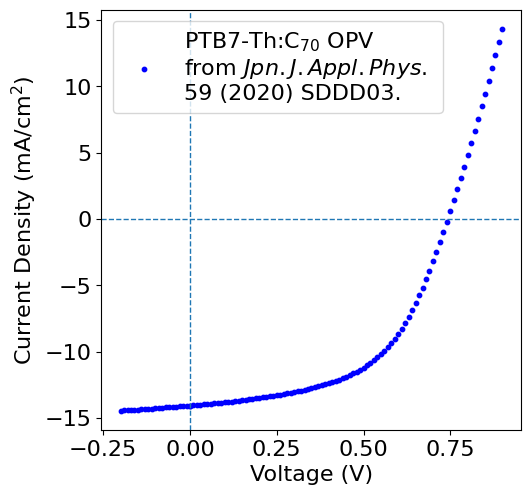

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current Density (mA/cm$^{2}$)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='PTB7-Th:C$_{70}$ OPV \nfrom $Jpn. J. Appl. Phys.$ \n59 (2020) SDDD03.'
           )
#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
#plt.title( r'Int. J. Sol. Ener. Cell' )
plt.legend()

In [ ]:
#
t0 = time.perf_counter()
#
with pm.Model() as model:
    Iph = pm.Uniform('Iph', lower=1e-2, upper=1e4 )  #mA
    Rp = pm.Uniform('Rp', lower=1e0, upper=1e5)      #Ohm
    Rs = pm.Uniform('Rs', lower=1e0, upper=1e8 )     #mOhm
    I0 = pm.Uniform('I0', lower=1e-1, upper=1e6 )    #nA
    n = pm.Uniform('n', lower=0.5, upper=500 )       #Vt(RT)=26 mV
#
    rmsd = pm.Uniform('rmsd', lower=0, upper=1e-2)
    mu = pm_I_Roberts_g(Iph, Rp, Rs, I0, n, X)
#
    y = pm.Normal('y', mu=mu, sigma=rmsd, observed=Y)
#
    trace_numpyro = pm.sampling_jax.sample_numpyro_nuts(10000, tune=10000, chains=2, target_accept=0.99)
#
t1 = time.perf_counter()
print( "elapsed time %.3f sec" % (t1-t0)  )

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

elapsed time 481.043 sec


In [ ]:
def Roberts_g(x):
    if x <= -(np.exp(-1)):
        g = x
    elif x >= (np.exp(1)):
        g = np.log(x)
    else:
        g = -np.exp(1) + (1 + np.exp(1)) / (2 * np.exp(1)) * (x + np.exp(1))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [ ]:
def I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026     #Vt(RT)=26 mV
    LogQ = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt
    return (V - nVt * (Roberts_g(LogQ) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [ ]:
def calcI(Iph, Rp, Rs, I0, n, V):
    V_list = V.tolist()
    I_list = [I_Roberts_g(Iph, Rp, Rs, I0, n, item) for item in V_list]
    return np.array(I_list)

In [ ]:
az.summary(trace_numpyro)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Iph,14.289,0.019,14.253,14.326,0.000,0.000,6505.0,8157.0,1.0
Rp,336.797,9.665,318.481,354.698,0.131,0.093,5482.0,7159.0,1.0
Rs,6762.226,107.331,6569.644,6972.178,1.521,1.075,4996.0,6617.0,1.0
I0,581.793,125.118,360.705,819.943,1.838,1.308,4699.0,5501.0,1.0
n,2.872,0.061,2.757,2.987,0.001,0.001,4702.0,5523.0,1.0
rmsd,0.000,0.000,0.000,0.000,0.000,0.000,8824.0,8651.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


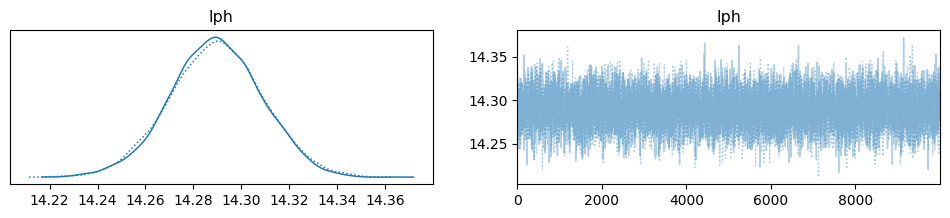

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Iph'))

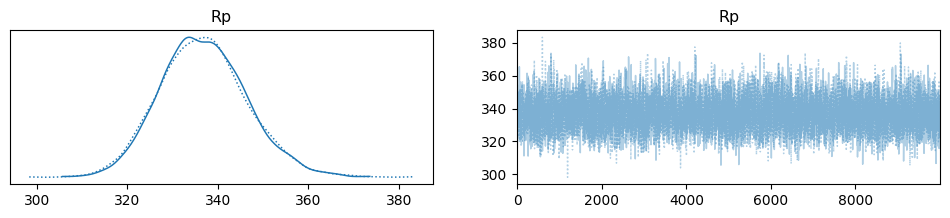

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rp'))

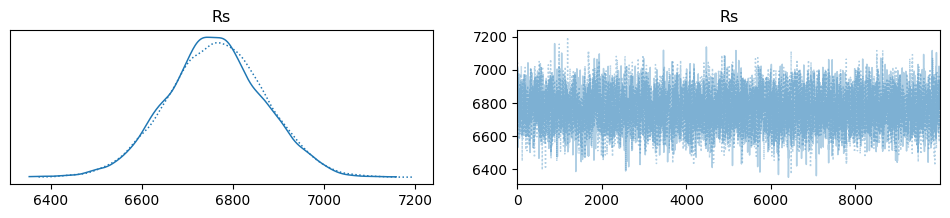

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('Rs'))

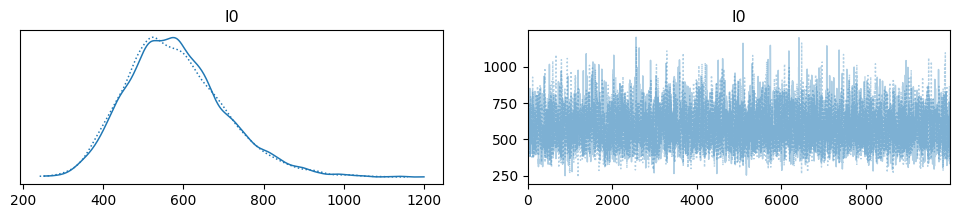

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('I0'))

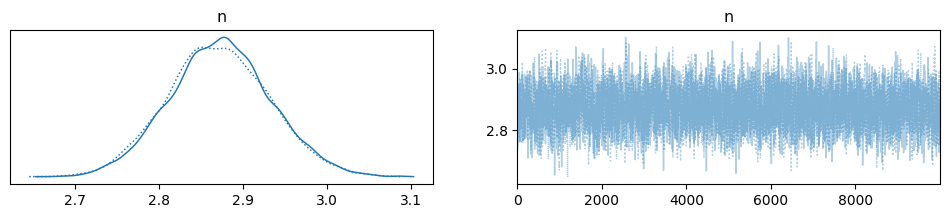

In [ ]:
with model:
  az.plot_trace(trace_numpyro, var_names=('n'))

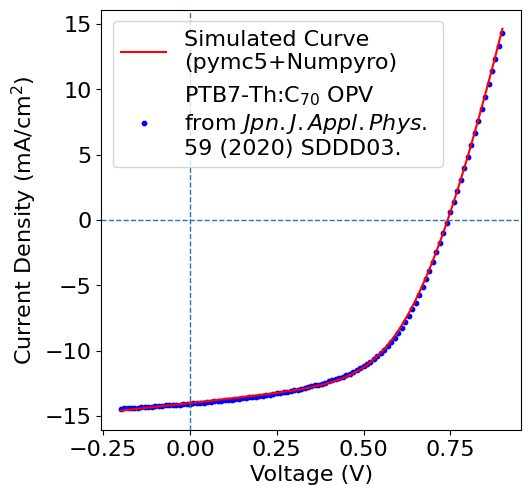

In [ ]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current Density (mA/cm$^{2}$)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='PTB7-Th:C$_{70}$ OPV \nfrom $Jpn. J. Appl. Phys.$ \n59 (2020) SDDD03.'
           )

xmin = np.amin(X)
xmax = np.amax(X)
N = 100
X_range = np.linspace(xmin, xmax, num=N, endpoint=True )

Q = az.summary(trace_numpyro)
Iph_m = Q.loc['Iph','mean']
Rp_m = Q.loc['Rp','mean']
Rs_m = Q.loc['Rs','mean']
I0_m = Q.loc['I0','mean']
n_m = Q.loc['n','mean']
I_list = calcI(Iph_m, Rp_m, Rs_m, I0_m, n_m, X_range)

ax1.plot(X_range, I_list*1e3, color='red',
            label='Simulated Curve\n(pymc5+Numpyro)'
           )

#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])